# Einops tutorial, part 1: basics

<img src='http://arogozhnikov.github.io/images/einops/einops_logo_350x350.png' height="80" />

## Welcome to einops-land!

We don't write code like
```python
y = x.transpose(0, 2, 3, 1)
```
We write comprehensible code
```python
y = rearrange(x, 'b c h w -> b h w c')
```


`einops` supports widely used tensor packages (such as `numpy`, `pytorch`, `chainer`, `gluon`, `tensorflow`), and extends them.

## What's in this tutorial?

- fundamentals: reordering, composition and decomposition of axes
- operations: `rearrange`, `reduce`, `repeat`
- how much you can do with a single operation!


## Preparations

Let's setup jupyter so it always renders `numpy` arrays to images.

In [1]:
import numpy

from PIL.Image import fromarray
from IPython import get_ipython
def numpy_to_png(a):
    assert 2 <= len(a.shape) <= 3, "Can't display {}-dimensional array of shape {}"\
        .format(len(a.shape), a.shape)
    return fromarray(numpy.array(numpy.clip(a, 0, 1) * 255, dtype='uint8'))._repr_png_()

get_ipython().display_formatter.formatters['image/png'].for_type(numpy.ndarray, numpy_to_png)
get_ipython().display_formatter.formatters['text/plain'].for_type(numpy.ndarray, lambda *x: "");

## Load a batch of images to play with

In [2]:
ims = numpy.load('./resources/test_images.npy', allow_pickle=False)
# There are 6 images of shape 96x96 with 3 color channels packed into tensor
print(ims.shape, ims.dtype)

(6, 96, 96, 3) float64


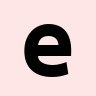

In [3]:
# display the first image (whole 4d tensor can't be rendered)
ims[0]

In [4]:
# we'll use three operations
from einops import rearrange, reduce, repeat

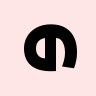

In [5]:
# rearrange, as its name suggests, rearranges elements
# below we swapped height and width.
# In other words, transposed first two axes (dimensions)
rearrange(ims[0], 'h w c -> w h c')

## Composition of axes
transposition is very common and useful, but let's move to other capabilities provided by einops

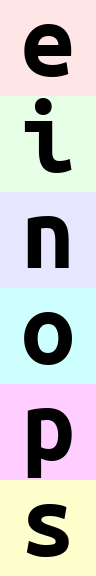

In [6]:
# einops allows seamlessly composing batch and height to a new height dimension
# We just redered all images by collapsing to 3d tensor!
rearrange(ims, 'b h w c -> (b h) w c')

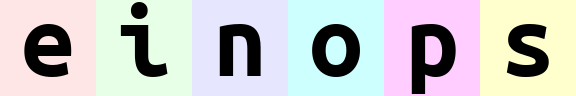

In [7]:
# or compose a new dimension of batch and width
rearrange(ims, 'b h w c -> h (b w) c')

In [8]:
# resulting dimensions are computed very simply
# length of newly composed axis is a product of components
# [6, 96, 96, 3] -> [96, (6 * 96), 3]
rearrange(ims, 'b h w c -> h (b w) c').shape

(96, 576, 3)

In [9]:
# we can compose more than two axes. 
# let's flatten 4d array into 1d, resulting array has as many elements as the original
rearrange(ims, 'b h w c -> (b h w c)').shape

(165888,)

## Axis decomposition

In [10]:
# decomposition is the inverse process - represent an axis as a combination of new axes
# several decompositions possible, so b1=2 is to decompose 6 to b1=2 and b2=3
rearrange(ims, '(b1 b2) h w c -> b1 b2 h w c ', b1=2).shape

(2, 3, 96, 96, 3)

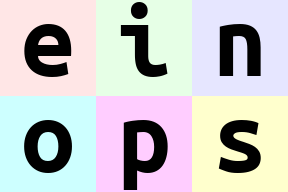

In [11]:
# finally, combine composition and decomposition:
rearrange(ims, '(b1 b2) h w c -> (b1 h) (b2 w) c ', b1=2)

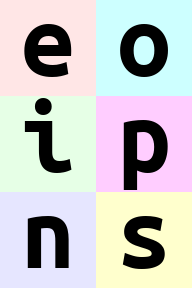

In [12]:
# slightly different composition: b1 is merged with width, b2 with height
# ... so letters are ordered by w then by h
rearrange(ims, '(b1 b2) h w c -> (b2 h) (b1 w) c ', b1=2)

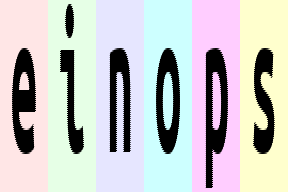

In [13]:
# move part of width dimension to height. 
# we should call this width-to-height as image width shrinked by 2 and height doubled. 
# but all pixels are the same!
# Can you write reverse operation (height-to-width)?
rearrange(ims, 'b h (w w2) c -> (h w2) (b w) c', w2=2)

## Order of axes matters

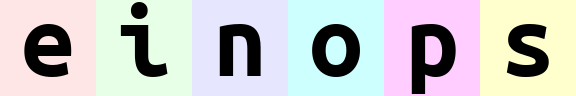

In [14]:
# compare with the next example
rearrange(ims, 'b h w c -> h (b w) c')

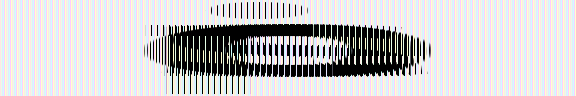

In [15]:
# order of axes in composition is different
# rule is just as for digits in the number: leftmost digit is the most significant, 
# while neighboring numbers differ in the rightmost axis.

# you can also think of this as lexicographic sort
rearrange(ims, 'b h w c -> h (w b) c')

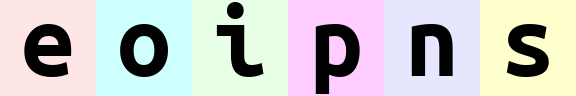

In [16]:
# what if b1 and b2 are reordered before composing to width?
rearrange(ims, '(b1 b2) h w c -> h (b1 b2 w) c ', b1=2) # produces 'einops'
rearrange(ims, '(b1 b2) h w c -> h (b2 b1 w) c ', b1=2) # produces 'eoipns'

## einops.reduce

In einops-land you don't need to guess what happened
```python
x.mean(-1)
```
Because you write what the operation does
```python
reduce(x, 'b h w c -> b h w', 'mean')
```

if axis is not present in the output - you guessed it right - it was reduced.

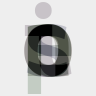

In [17]:
# average over batch
reduce(ims, 'b h w c -> h w c', 'mean')

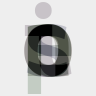

In [18]:
# the previous is identical to familiar:
ims.mean(axis=0)
# but so much more readable

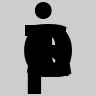

In [19]:
# Example of reducing of several axes 
# besides mean, there are also min, max, sum, prod
reduce(ims, 'b h w c -> h w', 'min')

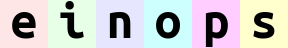

In [20]:
# this is mean-pooling with 2x2 kernel
# image is split into 2x2 patches, each patch is averaged
reduce(ims, 'b (h h2) (w w2) c -> h (b w) c', 'mean', h2=2, w2=2)

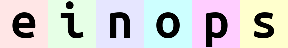

In [21]:
# max-pooling is similar
# result is not as smmoth as for mean-pooling
reduce(ims, 'b (h h2) (w w2) c -> h (b w) c', 'max', h2=2, w2=2)

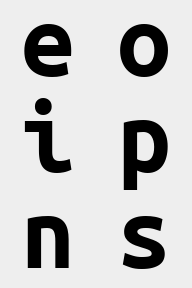

In [22]:
# yet another example. Can you compute result shape?
reduce(ims, '(b1 b2) h w c -> (b2 h) (b1 w)', 'mean', b1=2)

## Stack and concatenate

In [23]:
# rearrange can also take care of lists of arrays with the same shape
x = list(ims)
print(type(x), 'with', len(x), 'tensors of shape', x[0].shape)
# that's how we can stack inputs
# "list axis" becomes first ("b" in this case), and we left it there
rearrange(x, 'b h w c -> b h w c').shape

<class 'list'> with 6 tensors of shape (96, 96, 3)


(6, 96, 96, 3)

In [24]:
# but new axis can appear in the other place:
rearrange(x, 'b h w c -> h w c b').shape

(96, 96, 3, 6)

In [25]:
# that's the way numpy stacking works:
numpy.array_equal(rearrange(x, 'b h w c -> h w c b'), numpy.stack(x, axis=3))

True

In [26]:
# ... or we can concatenate 
rearrange(x, 'b h w c -> h (b w) c').shape  # numpy.stack(x, axis=3))

(96, 576, 3)

In [27]:
# which is behavior of concatenation
numpy.array_equal(rearrange(x, 'b h w c -> h (b w) c'), numpy.concatenate(x, axis=1))

True

## Reduce &lrarr; repeat

reduce and repeat are like opposite of each other: first one reduces amount of elements, second one increases

In [28]:
e_letter = ims[0]

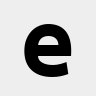

In [29]:
# in this example we first reduced channel axis
grayscale_letter = reduce(e_letter, 'h w 3 -> h w', 'mean')
# then introduced color channel back by repeating value in each channel
repeat(grayscale_letter, 'h w -> h w color', color=3)

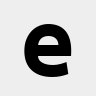

In [30]:
# no need to use names for axes that present only on one side of expression
repeat(grayscale_letter, 'h w -> h w 3')

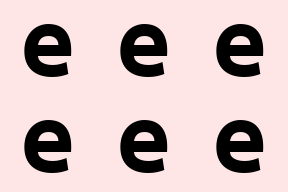

In [31]:
# two times repeat in height, 3 in width
repeat(e_letter, 'h w c -> (2 h) (3 w) c')

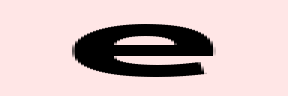

In [32]:
# repeat each pixel 3 times (again, we employ order of axes!)
repeat(e_letter, 'h w c -> h (w 3) c')

## Custom reductions

if reduction you want is missing (l1/l2 norm), it can be provided with callable

In [33]:
# as an example here l_inf norm is provided
def l_inf_norm(x, axes):
    return numpy.max(abs(x), axes)

reduce(ims, 'b h w c -> h w', l_inf_norm).shape

(96, 96)

## Composition of 0 axes

- What is a composition of 0 axes ` () `? 
    - this axis has length 1!
- `numpy` and other packages automatically broadcast axes of length 1 (thus 1 becomes slightly "magic")
- `einops` is completely uniform and has no "special" cases, but naturally incorporates tools for axes of length 1
- that said, many people prefer just writing 1, so it is also allowed

In [34]:
print(rearrange(ims, 'b h w c -> (b h)  (w c)').shape)
print(rearrange(ims, 'b h w c -> (b h w)  (c)').shape)
print(rearrange(ims, 'b h w c -> (b h w c) ()').shape)

(576, 288)
(55296, 3)
(165888, 1)


In [35]:
# () and 1 are in fact synonyms
x = rearrange(ims, 'b h w c -> b 1 h w 1 c') # functionality of numpy.expand_dims
print(x.shape)
print(rearrange(x, 'b 1 h w 1 c -> b h w c').shape) # functionality of numpy.squeeze

(6, 1, 96, 96, 1, 3)
(6, 96, 96, 3)


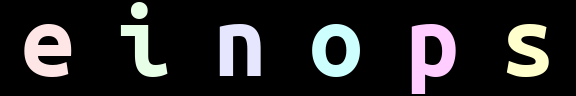

In [36]:
# compute max in each image individually, then show a difference 
x = reduce(ims, 'b h w c -> b () () c', 'max') - ims
rearrange(x, 'b h w c -> h (b w) c')

# Fancy examples in random order

(a.k.a. mad designer gallery)

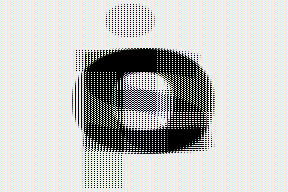

In [37]:
# interweaving pixels of different pictures
# all letters are observable
rearrange(ims, '(b1 b2) h w c -> (h b1) (w b2) c ', b1=2)

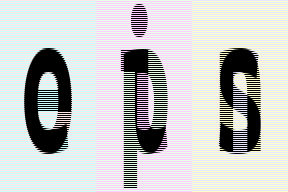

In [38]:
# interweaving along vertical for couples of images
rearrange(ims, '(b1 b2) h w c -> (h b1) (b2 w) c', b1=2)

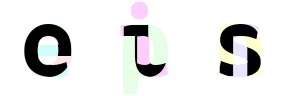

In [39]:
# interweaving lines for couples of images
# exercise: achieve the same result without einops in your favourite framework
reduce(ims, '(b1 b2) h w c -> h (b2 w) c', 'max', b1=2)

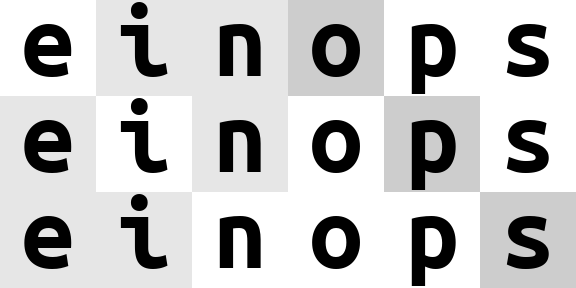

In [40]:
# color can be also composed into dimension
rearrange(ims, 'b h w c -> (c h) (b w)')

In [41]:
# disproportionate resize
reduce(ims, 'b (h1 h2) (w1 w2) c -> (h1) (b w1)', 'mean', w2=3, h2=4)

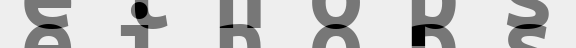

In [42]:
# spilt each image in two halves, compute mean of the two
reduce(ims, 'b (h1 h2) w c -> h2 (b w)', 'mean', h1=2)

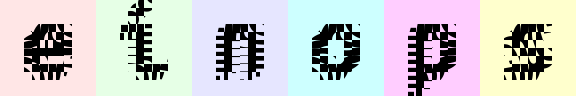

In [43]:
# split in small patches and transpose each patch
rearrange(ims, 'b (h1 h2) (w1 w2) c -> (h1 w2) (b w1 h2) c', h2=8, w2=8)

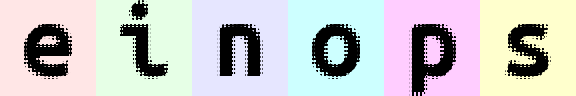

In [44]:
# stop me someone!
rearrange(ims, 'b (h1 h2 h3) (w1 w2 w3) c -> (h1 w2 h3) (b w1 h2 w3) c', h2=2, w2=2, w3=2, h3=2)

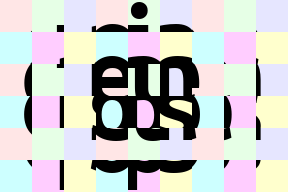

In [45]:
rearrange(ims, '(b1 b2) (h1 h2) (w1 w2) c -> (h1 b1 h2) (w1 b2 w2) c', h1=3, w1=3, b2=3)

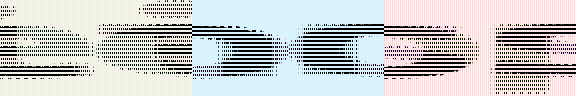

In [46]:
# it will take much time to describa what happened
reduce(ims, '(b1 b2) (h1 h2 h3) (w1 w2 w3) c -> (h1 w1 h3) (b1 w2 h2 w3 b2) c', 'mean', 
       h2=2, w1=2, w3=2, h3=2, b2=2)

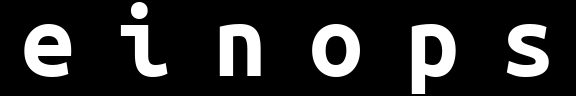

In [47]:
# subtract background in each image individually and normalize
# pay attention to () - this is composition of 0 axis, a dummy axis with 1 element.
im2 = reduce(ims, 'b h w c -> b () () c', 'max') - ims
im2 /= reduce(im2, 'b h w c -> b () () c', 'max')
rearrange(im2, 'b h w c -> h (b w) c')

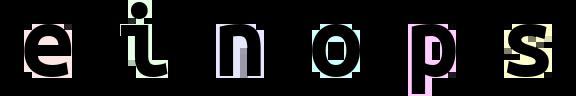

In [48]:
# subtract componentwise minimum individually for each patch
x = rearrange(ims, 'b (h h2) (w w2) c -> h h2 (b w) w2 c', h2=6, w2=8)
x -= reduce(x, 'h h2 w w2 c -> h () w () c', 'min')
rearrange(x, 'h h2 w w2 c -> (h h2) (w w2) c')

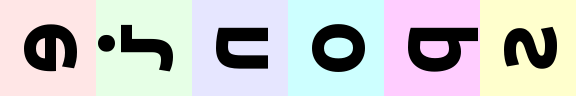

In [49]:
rearrange(ims, 'b h w c -> w (b h) c')

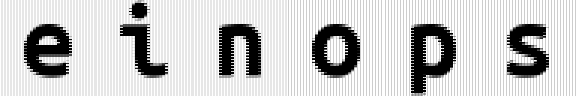

In [50]:
# let's bring color dimension as part of horizontal axis
reduce(ims, 'b (h h2) (w w2) c -> (h w2) (b w c)', 'mean', h2=3, w2=3)

## Ok, numpy is fun, but how do I use einops with some other framework?

If that's what you've done with `ims` being numpy array:
```python
rearrange(ims, 'b h w c -> w (b h) c')
```
That's how you adapt the code for other frameworks:

```python
# pytorch:
rearrange(ims, 'b h w c -> w (b h) c')
# tensorflow:
rearrange(ims, 'b h w c -> w (b h) c')
# chainer:
rearrange(ims, 'b h w c -> w (b h) c')
# gluon:
rearrange(ims, 'b h w c -> w (b h) c')
# cupy:
rearrange(ims, 'b h w c -> w (b h) c')
# jax:
rearrange(ims, 'b h w c -> w (b h) c')

...well, you got the idea.
```

Einops allows backpropagation as if all operations were native to framework.
Operations do not change when moving to another framework

# Summary

- composition and decomposition of axes are a corner stone, they can and should be used together
- `rearrange` doesn't change number of elements and covers different numpy functions (like `transpose`, `reshape`, `stack`, `concatenate`,  `squeeze` and `expand_dims`) 
- `reduce` combines same reordering syntax with reductions (`mean`, `min`, `max`, `sum`, `prod`, and any others)
- `repeat` additionally covers repeating and tiling


- [Second part of tutorial](https://github.com/arogozhnikov/einops/tree/master/docs) shows how einops works with other frameworks
- [Third part of tutorial](https://arogozhnikov.github.io/einops/pytorch-examples.html) shows how to improve your DL code with einops